# Analiza datasetu Gender, Mental Illness, and Crime in the United States, 2004 (ICPSR 27521)

Szymon Zalas 147493

Na podstawie https://put-jug.github.io/lab-ead/Lab%2010%20-%20Projekt%20blok2_2024.html

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
import ppscore as pps
import sklearn
from sklearn.model_selection import train_test_split

## 0) Omówienie Projektu

### a) Opis próby

Celem projetku jest znalezienie czynników odpowiedzialnych za depresję, tak żeby po ich określeniu można było dokonać oceny ryzyka depresji w danej grupie wiekowej na podstawie datasetu Gender, Mental Illness, and Crime in the United States, 2004 (ICPSR 27521). Próba obejmowała 67 760 osób, z czego plik zawiera 55 602 rekordów ze względu na resampling stosowany w procesie anonimizacji. Stratyfikacja próby jest wielopoziomowa, zaczynając od stanów, gdzie 8 jest uważanych za stany o dużej próbie i wnoszą ok. 3600 respondentów na stan. Reszta stanów obejmuje ok 900 respondentów. 

 Próbkowanie obejmowało pięć grup wiekowych: 
- 12–17 lat,
- 18–25 lat,
- 26–34 lata,
- 35–49 lat,
- 50 lat i więcej.

Projekt próby obejmował mniej więcej równą liczbę osób w grupach wiekowych:
- 12–17 lat,
- 18–25 lat,
- 26 lat i starszych.

In [2]:
base_df=pd.read_csv('27521-0001-Data.tsv', sep='\t',header=0)

### b) Opis zmiennych

In [3]:
extracted_variables=[]

#### Wskaźniki depresji

- DEPRESSIONINDEX - wskaźnik natężenia depresji w skali 0-9 dla grupy dorosłych i w wieku młodzieńczym (brak odpowiedzi = -9)
- DEPEPISODE - doświadczenie epizodu depresji w okresie całego zycia
- MDELASTYR - epizod depresji w ostatnim roku
- ANYTXRXMDE - jakiklolwiek zdarzenie zawiązane z leczeniem depresji lub receptą na leki antydepresyjne w minionym roku

In [4]:
depression_variables=['DEPRESSIONINDEX','DEPEPISODE','MDELASTYR','ANYTXRXMDE']
extracted_variables.extend(depression_variables)

#### Wskaźniki wieku

- CATAG2 - 3 grupy wiekowe: 12-17, 18-25, >25
- CATAG3 - równoliczne 5 kategorii wiekowych
- CATAG7 - równoliczne 7 kategorii wiekowych

Grupa wiekowa (12-17 (youth)) ma w pewnych obszarach inne zestawy pytań niż grupy starsze (rozróżnienie jest kodowane w nazwach kolumn YOxxx lub ADxx)

In [5]:
age_variables=['CATAG2','CATAG3','CATAG7']
extracted_variables.extend(age_variables)

#### Wskaźnik płci

- IRSEX - rozróżnia płeć biologiczną

In [6]:
sex_variables=['IRSEX']
extracted_variables.extend(sex_variables)

#### Wskaźnik rasy

- NEWRACE2 (1-7)
    1) NonHisp White
    2) NonHisp Black/Afr
    3) NonHisp Native Am/AK Native
    4) NonHisp Native HI/Other Pac Isl
    5) NonHisp Asian
    6) NonHisp more than one race
    7) Hispanic


In [7]:
racial_variables=['NEWRACE2']
extracted_variables.extend(racial_variables)

#### Wskaźnik uzależnienia od narkotyków i alkoholu

- ANYINDEX - wskaźnik uzależnienia od dowolnego rodzaju narkotyków (boolean)
- MJANDCOKE - marihuana lub kokaina (kiedykolwiek)
- ILLICITDRUGUSE - nielegalny narkotyk (kiedykolwiek)
- LSYRILLICIT - nielegalny narkotyk (ostatni rok)
- COKECRACK - kokaina lub crack 
- OTHERILLICIT - inne nielegalne poza kokaina lub marihuaną (kiedykolwiek)
- MARJLTYR - marihuana (ostatni rok)
- MJCOKELY - marihuana, kokaina, crack (ostatni rok)
- COCCRKLY - kokaina (ostatni rok)
- MJGT12MO - marihuana (upłynęło więcej niż 12msc)
- COCGT12MO - kokaina (upłynęło więcej niż 12msc)
- ANYGT12MO - jakikolwiek narkotyck (upłynęło więcej niż 12msc)
- ALCFMFPB - alkohol powodował problemy wśród rodziny/przyjaciół (ostatni rok)


In [8]:
drug_variables=['ANYINDEX','MJANDCOKE', 'ILLICITDRUGUSE', 'LSYRILLICIT', 'COKECRACK', 'OTHERILLICIT','MARJLTYR', 'MJCOKELY', 'COCCRKLY','MJGT12MO', 'COCGT12MO', 'ANYGT12MO','ALCFMFPB']
extracted_variables.extend(drug_variables)

#### Wskaźnik edukacji

- IREDUC2 - wykształcenie
- EDU_DUMMY - wykształcenie (średnie/niższe od średniego lub wyższe)

In [9]:
education_variables=['IREDUC2','EDU_DUMMY']
extracted_variables.extend(education_variables)

#### Wskaźniki ekonomiczne

- INCOME - dochód rodziny
- INCOME_R - dochód własny
- POVERTY - dochód rodziny odniesiony do wskaźnika biedy
- IRPRVHLT - prywatne ubezpieczenie zdrowotne
- WORKFORCE - informacja czy osoba pracuje/pracowała
- EMPSTAT4 - status zatrudnienia

In [10]:
economic_variables=['INCOME','INCOME_R','POVERTY','IRPRVHLT','WORKFORCE','EMPSTAT4']
extracted_variables.extend(economic_variables)

#### Wskaźniki warunków zamieszkania

- REVERSEPOP - charakterystyka miejsca zamieszkania (gęstość zaludnienia)
- MOVESPY2 - liczba przeprowadzek w okresie ostatnich 12 miesięcy
- CACHAR, CATYPE - typ mieszkania

In [11]:
accomodation_variables=['REVERSEPOP','MOVESPY2','CACHAR','CATYPE']
extracted_variables.extend(accomodation_variables)

#### Wskaźnik konfliktów z prawem

- CRIMEHIST - kiedykolwiek aresztowany
- ANYSDRUG - sprzedarz narkotyków (ostatnie 12 msc)
- ANYATTACK - atak na inną osobę (ostatnie 12 msc)
- ANYTHEFT - kradzież przedmiotu o wartości min 50$ (ostatnie 12 msc)
- NUMARREST - liczba aresztowań (ostatnie 12 msc)

In [12]:
law_problems_variables=['CRIMEHIST','ANYSDRUG','ANYATTACK','ANYTHEFT','NUMARREST']
extracted_variables.extend(law_problems_variables)

#### Stan zdrowia

- HEALTH2 - stan zdrowia
- SCHDSICK - liczba dni opuszczonych w szkole z uwagi choroby (dla uczniów)
- SCHDSKIP - liczba dni opuszczony z powodu wagarów
- TXLCAD - informacja o terapii uzależnień od narkotyków lub alkoholu
- DSTNCALM - jak często nie mógł się uspokoić w najgorszych miesiącach
- DSTTIRE - jak często był wycięczony w najgorszych miesiącach
- DSTSITST - jak często nie mógł usiedzieć na miejscu w najgorszych miesiącach
- DSTDEPRS - jak często miał poczucie depresji w najgorszych miesiącach
- DSTCHEER - jak często nie mógł być pocieszony w najgorszych miesiącach
- DSTNRVOS - jak często czuł stany nerwowe w najgorszych miesiącach
- ADWRELES - mniejszy apetyt w najgorszych miesiącach
- ADWRSMOR - problemy ze snem
- ADWRSTHK - myśli samobójcze
- YOWRSATP - próba samobójcza

In [13]:
health_based_var=['HEALTH2', 'SCHDSICK', 'SCHDSKIP', 'TXLCAD', 'DSTNCALM', 'DSTTIRE', 'DSTSITST', 'DSTDEPRS', 'DSTCHEER', 'DSTNRVOS', 'ADWRELES', 'ADWRSMOR', 'ADWRSTHK', 'YOWRSATP']
extracted_variables.extend(health_based_var)

#### Rodzina

- IRMARIT - stan cywilny
- NOMARR2 - liczba razy kiedy osoba wchodziła w związek małżeński
- RKIDSHH - liczba dzieci respondent
- MARRIED - aktualny stan cywilny
- CHILDRENINHOME - czy ma dzieci (min 1)

In [14]:
family_variables=['IRMARIT','NOMARR2','RKIDSHH','MARRIED','CHILDRENINHOME']
extracted_variables.extend(family_variables)

In [15]:
main_df=base_df[extracted_variables] # extract the variables of interest
main_df

,DEPRESSIONINDEX,DEPEPISODE,MDELASTYR,ANYTXRXMDE,CATAG2,CATAG3,CATAG7,IRSEX,NEWRACE2,ANYINDEX,...,DSTNRVOS,ADWRELES,ADWRSMOR,ADWRSTHK,YOWRSATP,IRMARIT,NOMARR2,RKIDSHH,MARRIED,CHILDRENINHOME
0,0,0,0,0,2,2,5,1,7,0.142857,...,4,99,99,99,99,4,99,0,0,0
1,0,0,0,0,2,2,4,1,1,0.142857,...,4,99,99,99,99,4,99,0,0,0
2,0,0,0,0,3,5,7,1,1,0.142857,...,5,99,99,99,99,1,1,0,1,0
3,0,0,0,0,2,2,5,1,1,0.500000,...,4,99,99,99,99,4,99,0,0,0
4,0,0,0,0,3,4,7,2,1,0.142857,...,3,99,99,99,99,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55597,-9,-1,-1,-9,2,2,5,1,1,0.142857,...,5,99,99,99,99,4,99,0,0,0
55598,0,0,0,0,2,2,5,1,1,0.142857,...,4,99,99,99,99,1,1,1,1,1
55599,-9,-1,-1,-9,2,2,5,2,1,0.142857,...,5,99,99,99,99,1,1,1,1,1
55600,0,0,0,0,3,3,6,1,1,0.142857,...,3,99,99,99,99,1,1,0,1,0


## 1) FAZA 1 - Czyszczenie danych i analiza czynnikowa 

### a) Czyszczenie danych

In [16]:
main_df.isna().sum().max()

0

Dane zawarte w datasecie zostały już częściowo oczyszczone a w dokumencie opisującym, możemy znaleść dokładne oznaczenia powodów brakujących danych. Typowo, brakujące dane są oznaczane albo wartością ujemną albo bardzo wysoką (powyżej 80), przy czym wartość 99 oznacza uzasadnione pominięcie pytania.

In [17]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
print(invalid_counts)

DEPRESSIONINDEX    18630
DEPEPISODE         19019
MDELASTYR          19070
ANYTXRXMDE         18963
ANYINDEX              35
COKECRACK           1705
MJGT12MO            1930
COCGT12MO            781
ANYGT12MO           2410
ALCFMFPB           28140
WORKFORCE             21
CACHAR                 7
CATYPE               121
CRIMEHIST            159
ANYSDRUG             167
ANYATTACK            116
ANYTHEFT             123
NUMARREST            853
HEALTH2               12
SCHDSICK            3447
SCHDSKIP              72
TXLCAD             54622
DSTNCALM             221
DSTTIRE              163
DSTSITST             174
DSTDEPRS             143
DSTCHEER             283
DSTNRVOS             350
ADWRELES             147
ADWRSMOR             135
ADWRSTHK             136
YOWRSATP             227
NOMARR2               13
RKIDSHH               45
dtype: int64


In [18]:
len_0=main_df.shape[0]
print(f'Aktualna liczba danych: {len_0}')
print(f'Najwyższa liczba nieprawidłowych wartości: {invalid_counts.max()} dla zmiennej {invalid_counts.idxmax()}')
print(f'Najniższa liczba nieprawidłowych wartości: {invalid_counts.min()} dla zmiennej {invalid_counts.idxmin()}')

Aktualna liczba danych: 55602
Najwyższa liczba nieprawidłowych wartości: 54622 dla zmiennej TXLCAD
Najniższa liczba nieprawidłowych wartości: 7 dla zmiennej CACHAR


#### Czyszczenie analityczne

Początkowo pozbędziemy się wierszy w których wszystkie informacje dotyczące wystąpienia depresji są mniejsze od 0 - nie jesteśmy w stanie przewidzieć jaka jest tam prawdziwa odpowiedź

In [19]:
columns_to_check = ['DEPRESSIONINDEX', 'DEPEPISODE', 'MDELASTYR', 'ANYTXRXMDE']
mask = (main_df[columns_to_check] >= 0).all(axis=1)
main_df = main_df[mask]

In [20]:
len_1=main_df.shape[0]
print(f'Aktualna liczba danych: {len_1}')
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
print(f'Najwyższa liczba nieprawidłowych wartości: {invalid_counts.max()} dla zmiennej {invalid_counts.idxmax()}')
print(f'Najniższa liczba nieprawidłowych wartości: {invalid_counts.min()} dla zmiennej {invalid_counts.idxmin()}')

Aktualna liczba danych: 36505
Najwyższa liczba nieprawidłowych wartości: 35899 dla zmiennej TXLCAD
Najniższa liczba nieprawidłowych wartości: 4 dla zmiennej WORKFORCE


Sprawdźmy rezultat

In [21]:
pivot_dfs = []

for col in columns_to_check:
    df_temp = pd.crosstab(index=main_df[col][main_df[col] >= 0], columns=col)
    df_temp.loc['Total'] = df_temp.sum()
    pivot_dfs.append(df_temp)

result = pd.concat(pivot_dfs, axis=1)
print(result)

col_0  DEPRESSIONINDEX  DEPEPISODE  MDELASTYR  ANYTXRXMDE
0                30076     30773.0    32999.0     34108.0
1                  112      5732.0     3506.0      2397.0
2                   71         NaN        NaN         NaN
3                  170         NaN        NaN         NaN
4                  344         NaN        NaN         NaN
5                  599         NaN        NaN         NaN
6                  954         NaN        NaN         NaN
7                 1313         NaN        NaN         NaN
8                 1543         NaN        NaN         NaN
9                 1323         NaN        NaN         NaN
Total            36505     36505.0    36505.0     36505.0


Poszukajmy kolumn w których ponad 90% wartości jest nieprawidłowa...

In [22]:
th_len=int(len_1*0.9)
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > th_len]
print(invalid_counts)

TXLCAD    35899
dtype: int64


... a następnie je wyrzućmy.

In [23]:
main_df = main_df.drop(columns=invalid_counts.index)

In [24]:
len_2=main_df.shape[0]
print(f'Aktualna liczba danych: {len_2}')
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
print(f'Najwyższa liczba nieprawidłowych wartości: {invalid_counts.max()} dla zmiennej {invalid_counts.idxmax()}')
print(f'Najniższa liczba nieprawidłowych wartości: {invalid_counts.min()} dla zmiennej {invalid_counts.idxmin()}')

Aktualna liczba danych: 36505
Najwyższa liczba nieprawidłowych wartości: 21012 dla zmiennej ALCFMFPB
Najniższa liczba nieprawidłowych wartości: 4 dla zmiennej WORKFORCE


In [25]:
print(invalid_counts)

ANYINDEX        24
COKECRACK      924
MJGT12MO      1606
COCGT12MO      515
ANYGT12MO     2010
ALCFMFPB     21012
WORKFORCE        4
CACHAR           7
CATYPE          79
CRIMEHIST       74
ANYSDRUG        76
ANYATTACK       39
ANYTHEFT        49
NUMARREST      588
HEALTH2         10
SCHDSICK      2973
SCHDSKIP        42
DSTCHEER        66
DSTNRVOS        96
ADWRELES        16
ADWRSMOR         4
ADWRSTHK         8
YOWRSATP        31
NOMARR2         10
RKIDSHH         15
dtype: int64


Brakujące wartości w ALCMFPB odnoszą się do problemów związanych z piciem alkoholu, i na podstawie [icpsr](https://www.icpsr.umich.edu/web/NACJD/studies/27521/datasets/0001/variables/ALCFMFPB?archive=nacjd) możemy założyć że:
- wartości 83, 91, 93 raczej odnoszą się do braku problemów
- wartości 94, 97, 98 mogą być próbą uniknięcia udzielenie odpowiedzi ze wstydu, zostaną uznane jako wystąpienie problemów

In [26]:
value_map = {
    93: 0,
    91: 0,
    83: 0,
    94: 1,
    97: 1,
    98: 1
}
main_df['ALCFMFPB'] = main_df['ALCFMFPB'].replace(value_map)

In [27]:
len_3=main_df.shape[0]
print(f'Aktualna liczba danych: {len_3}')
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
print(f'Najwyższa liczba nieprawidłowych wartości: {invalid_counts.max()} dla zmiennej {invalid_counts.idxmax()}')
print(f'Najniższa liczba nieprawidłowych wartości: {invalid_counts.min()} dla zmiennej {invalid_counts.idxmin()}')

Aktualna liczba danych: 36505
Najwyższa liczba nieprawidłowych wartości: 2973 dla zmiennej SCHDSICK
Najniższa liczba nieprawidłowych wartości: 4 dla zmiennej WORKFORCE


In [28]:
print(invalid_counts)

ANYINDEX       24
COKECRACK     924
MJGT12MO     1606
COCGT12MO     515
ANYGT12MO    2010
WORKFORCE       4
CACHAR          7
CATYPE         79
CRIMEHIST      74
ANYSDRUG       76
ANYATTACK      39
ANYTHEFT       49
NUMARREST     588
HEALTH2        10
SCHDSICK     2973
SCHDSKIP       42
DSTCHEER       66
DSTNRVOS       96
ADWRELES       16
ADWRSMOR        4
ADWRSTHK        8
YOWRSATP       31
NOMARR2        10
RKIDSHH        15
dtype: int64


Przeanalizujmy jeszcze i wyczyśćmy kolumny dla których brakuje min. 500 pozycji

In [29]:
print(invalid_counts[invalid_counts > 500])


COKECRACK     924
MJGT12MO     1606
COCGT12MO     515
ANYGT12MO    2010
NUMARREST     588
SCHDSICK     2973
dtype: int64


In [30]:
remaining_columns = invalid_counts[invalid_counts > 500].index
remaining_columns

Index(['COKECRACK', 'MJGT12MO', 'COCGT12MO', 'ANYGT12MO', 'NUMARREST',
       'SCHDSICK'],
      dtype='object')

W przypadku zmiennych określających użycie narkotyków możemy założyć, że brak odpowiedzi oznacza, iż dana osoba brała dany narkotyk. Możemy to ustalić zakładając odwrotnie, że osoby które nie brały narkotyków chętniej zaznaczą że tego nie zrobiły.

In [31]:
value_map = {
    -1:1
}
main_df['COKECRACK'] = main_df['COKECRACK'].replace(value_map)
main_df['COKECRACK'].value_counts()

0    32871
1     3634
Name: COKECRACK, dtype: int64

Zamieniamy wartości MJGT12MO na 1 tam gdzie wcześniej wystąpił brak odpowiedzi (-9), a w kolumnie MJANDCOKE jest 1.

In [32]:
mask = (main_df['MJANDCOKE'] == 1) & (main_df['MJGT12MO'] == -9)
filtered_rows = main_df[mask]
print(f'MJANDCOKE==1 i MJGT12MO==-9: {mask.sum()}')
print("\nRzędy:")
print(filtered_rows[['MJANDCOKE', 'MJGT12MO']])

MJANDCOKE==1 i MJGT12MO==-9: 1606

Rzędy:
       MJANDCOKE  MJGT12MO
7              1        -9
32             1        -9
102            1        -9
124            1        -9
149            1        -9
...          ...       ...
55382          1        -9
55519          1        -9
55528          1        -9
55535          1        -9
55560          1        -9

[1606 rows x 2 columns]


In [33]:
main_df.loc[mask, 'MJGT12MO'] = 1
mask = (main_df['MJANDCOKE'] == 1) & (main_df['MJGT12MO'] == -9)
filtered_rows = main_df[mask]
print(f'MJANDCOKE==1 i MJGT12MO==-9: {mask.sum()}')
print("\nRzędy:")
print(filtered_rows[['MJANDCOKE', 'MJGT12MO']])

MJANDCOKE==1 i MJGT12MO==-9: 0

Rzędy:
Empty DataFrame
Columns: [MJANDCOKE, MJGT12MO]
Index: []


To samo zrobimy dla COCGT12MO.

In [34]:
mask = (main_df['MJANDCOKE'] == 1) & (main_df['COCGT12MO'] == -9)
filtered_rows = main_df[mask]
print(f'MJANDCOKE==1 i COCGT12MO==-9: {mask.sum()}')
print("\nRzędy:")
print(filtered_rows[['MJANDCOKE', 'COCGT12MO']])

MJANDCOKE==1 i COCGT12MO==-9: 515

Rzędy:
       MJANDCOKE  COCGT12MO
107            1         -9
125            1         -9
179            1         -9
281            1         -9
305            1         -9
...          ...        ...
55011          1         -9
55038          1         -9
55090          1         -9
55133          1         -9
55587          1         -9

[515 rows x 2 columns]


In [35]:
main_df.loc[mask, 'COCGT12MO'] = 1
mask = (main_df['MJANDCOKE'] == 1) & (main_df['COCGT12MO'] == -9)
filtered_rows = main_df[mask]
print(f'MJANDCOKE==1 i COCGT12MO==-9: {mask.sum()}')
print("\nRzędy:")
print(filtered_rows[['MJANDCOKE', 'COCGT12MO']])

MJANDCOKE==1 i COCGT12MO==-9: 0

Rzędy:
Empty DataFrame
Columns: [MJANDCOKE, COCGT12MO]
Index: []


Oraz dla ANYGT12MO z tym że porównujemy z OTHERILLICIT.

In [36]:
mask = (main_df['OTHERILLICIT'] == 1) & (main_df['ANYGT12MO'] == -9)
filtered_rows = main_df[mask]
print(f'OTHERILLICIT==1 i ANYGT12MO==-9: {mask.sum()}')
print("\nRzędy:")
print(filtered_rows[['OTHERILLICIT', 'ANYGT12MO']])

OTHERILLICIT==1 i ANYGT12MO==-9: 1093

Rzędy:
       OTHERILLICIT  ANYGT12MO
21                1         -9
86                1         -9
116               1         -9
192               1         -9
203               1         -9
...             ...        ...
55198             1         -9
55307             1         -9
55327             1         -9
55420             1         -9
55560             1         -9

[1093 rows x 2 columns]


In [37]:
main_df.loc[mask, 'ANYGT12MO'] = 1
mask = (main_df['OTHERILLICIT'] == 1) & (main_df['ANYGT12MO'] == -9)
filtered_rows = main_df[mask]
print(f'OTHERILLICIT==1 i ANYGT12MO==-9: {mask.sum()}')
print("\nRzędy:")
print(filtered_rows[['OTHERILLICIT', 'ANYGT12MO']])

OTHERILLICIT==1 i ANYGT12MO==-9: 0

Rzędy:
Empty DataFrame
Columns: [OTHERILLICIT, ANYGT12MO]
Index: []


W przypadku NUMARREST ciężko jest określić ile razy dana osoba mogła być aresztowana, dlatego wyrzucimy rzędy z brakującymi wartościami.

In [38]:
len_4 = len(main_df)
main_df = main_df[main_df['NUMARREST'] != -9]
len_5 = len(main_df)
print(f'Usunięto {len_4 - len_5} wierszy')
print(f'Pozostało {len_5} wierszy')


Usunięto 588 wierszy
Pozostało 35917 wierszy


SCHDSICK dotyczy jedynie młodzieży i nie jesteśmy w stanie dodać tej wartości dla dorosłych dlatego usuwamy kolumnę.

In [39]:
main_df = main_df.drop(columns='SCHDSICK')

In [40]:
len_6=main_df.shape[0]
print(f'Aktualna liczba danych: {len_6}')
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
print(f'Najwyższa liczba nieprawidłowych wartości: {invalid_counts.max()} dla zmiennej {invalid_counts.idxmax()}')
print(f'Najniższa liczba nieprawidłowych wartości: {invalid_counts.min()} dla zmiennej {invalid_counts.idxmin()}')

Aktualna liczba danych: 35917


Najwyższa liczba nieprawidłowych wartości: 895 dla zmiennej ANYGT12MO
Najniższa liczba nieprawidłowych wartości: 4 dla zmiennej WORKFORCE


In [41]:
print(invalid_counts)

ANYINDEX      23
ANYGT12MO    895
WORKFORCE      4
CACHAR         7
CATYPE        79
ANYSDRUG      69
ANYATTACK     36
ANYTHEFT      44
HEALTH2       10
SCHDSKIP      41
DSTCHEER      63
DSTNRVOS      91
ADWRELES      16
ADWRSMOR       4
ADWRSTHK       8
YOWRSATP      30
NOMARR2        9
RKIDSHH       13
dtype: int64


#### Masowe czyszczenie

Usuwamy rzędy lub kolumny danych gdzie pozostały dodatkowe brakujące wartości.

In [42]:
len_7=main_df.shape[0]
print(f'Aktualna liczba danych: {len_7}')
main_df = main_df[main_df['ANYGT12MO'] != -9]
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Aktualna liczba danych: 35917
Najwyższa liczba nieprawidłowych wartości: 91 dla zmiennej DSTNRVOS


In [43]:
print(main_df['DSTNRVOS'].value_counts().sort_index())

1       763
2      1872
3      4508
4      6375
5      4468
85        1
94       57
97       33
99    16945
Name: DSTNRVOS, dtype: int64


In [44]:
main_df = main_df.drop(columns='DSTNRVOS')

In [45]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 77 dla zmiennej CATYPE


In [46]:
print(main_df['CATYPE'].value_counts().sort_index())

-9       77
 1    30440
 2      795
 3      499
 4     1103
 5     1974
 6      134
Name: CATYPE, dtype: int64


In [47]:
main_df = main_df[main_df['CATYPE'] != -9]
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 68 dla zmiennej ANYSDRUG


In [48]:
print(main_df['ANYSDRUG'].value_counts().sort_index())

-1       68
 0    33638
 1     1239
Name: ANYSDRUG, dtype: int64


In [49]:
main_df = main_df[main_df['ANYSDRUG'] != -1]
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 57 dla zmiennej DSTCHEER


In [50]:
print(main_df['DSTCHEER'].value_counts().sort_index())

1       722
2      1503
3      2801
4      4167
5      8740
94       37
97       20
99    16887
Name: DSTCHEER, dtype: int64


In [51]:
value_map = {
    94:5,
    97:5,
    99:5
}
main_df['DSTCHEER'] = main_df['DSTCHEER'].replace(value_map)
main_df['DSTCHEER'].value_counts()

5    25684
4     4167
3     2801
2     1503
1      722
Name: DSTCHEER, dtype: int64

In [52]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 40 dla zmiennej SCHDSKIP


In [53]:
print(main_df['SCHDSKIP'].value_counts().sort_index())

0     14511
1      1116
2       683
3       300
4       164
5       156
6        48
7        31
8        22
9         6
10       42
12        7
13        3
14        3
15       11
17        1
20        9
21        1
25        3
26        1
29        1
30        4
94       20
97        2
98       18
99    17714
Name: SCHDSKIP, dtype: int64


In [54]:
main_df = main_df.drop(columns='SCHDSKIP')

In [55]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 26 dla zmiennej YOWRSATP


In [56]:
print(main_df['YOWRSATP'].value_counts().sort_index())

1       502
2       799
94        1
97        6
98       19
99    33550
Name: YOWRSATP, dtype: int64


In [57]:
value_map = {
    94:1,
    97:1,
    98:1,
    99:2
}
main_df['YOWRSATP'] = main_df['YOWRSATP'].replace(value_map)
main_df['YOWRSATP'].value_counts()

2    34349
1      528
Name: YOWRSATP, dtype: int64

In [58]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 21 dla zmiennej ANYINDEX


In [59]:
print(main_df['ANYINDEX'].value_counts().sort_index())

-1.000000       21
 0.142857    31752
 0.166667     1010
 0.285714      187
 0.333333      753
 0.428571      106
 0.500000      392
 0.571429      100
 0.666667      224
 0.714286       82
 0.833333      119
 0.857143       68
 1.000000       63
Name: ANYINDEX, dtype: int64


In [60]:
main_df = main_df[main_df['ANYINDEX'] != -1.000000]
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 16 dla zmiennej ANYATTACK


In [61]:
print(main_df['ANYATTACK'].value_counts().sort_index())

-1       16
 0    32946
 1     1894
Name: ANYATTACK, dtype: int64


In [62]:
main_df = main_df[main_df['ANYATTACK'] != -1]
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 15 dla zmiennej ADWRELES


In [63]:
print(main_df['ADWRELES'].value_counts().sort_index())

1      2070
2      1307
94       15
99    31448
Name: ADWRELES, dtype: int64


In [64]:
main_df = main_df[main_df['ADWRELES'] != 94]
value_map = {
    99:2
}
main_df['ADWRELES'] = main_df['ADWRELES'].replace(value_map)
main_df['ADWRELES'].value_counts()

2    32755
1     2070
Name: ADWRELES, dtype: int64

In [65]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 13 dla zmiennej RKIDSHH


In [66]:
print(main_df['RKIDSHH'].value_counts().sort_index())

-1       13
 0    28752
 1     6060
Name: RKIDSHH, dtype: int64


In [67]:
main_df = main_df[main_df['RKIDSHH'] != -1]

In [68]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 12 dla zmiennej ANYTHEFT


In [69]:
print(main_df['ANYTHEFT'].value_counts().sort_index())

-1       12
 0    33794
 1     1006
Name: ANYTHEFT, dtype: int64


In [70]:
main_df = main_df[main_df['ANYTHEFT'] != -1]

In [71]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 10 dla zmiennej HEALTH2


In [72]:
print(main_df['HEALTH2'].value_counts().sort_index())

-9       10
 1    10746
 2    13937
 3     7962
 4     2145
Name: HEALTH2, dtype: int64


In [73]:
main_df = main_df[main_df['HEALTH2'] != -9]

In [74]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 8 dla zmiennej NOMARR2


In [75]:
print(main_df['NOMARR2'].value_counts().sort_index())

1      7269
2      1843
94        1
97        7
99    25670
Name: NOMARR2, dtype: int64


In [76]:
main_df = main_df[main_df['NOMARR2'] != 94]
main_df = main_df[main_df['NOMARR2'] != 97]

In [77]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 7 dla zmiennej CACHAR


In [78]:
print(main_df['CACHAR'].value_counts().sort_index())

-9        7
 1       55
 2      612
 3       93
 4       88
 5       54
 6    26673
 7     3725
 8     1949
 9     1526
Name: CACHAR, dtype: int64


In [79]:
main_df = main_df[main_df['CACHAR'] != -9]

In [80]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 7 dla zmiennej ADWRSTHK


In [81]:
print(main_df['ADWRSTHK'].value_counts().sort_index())

1      1300
2      2065
94        5
97        2
99    31403
Name: ADWRSTHK, dtype: int64


In [82]:
value_map = {
    94:1,
    97:1,
    99:2
}
main_df['ADWRSTHK'] = main_df['ADWRSTHK'].replace(value_map)
main_df['ADWRSTHK'].value_counts()

2    33468
1     1307
Name: ADWRSTHK, dtype: int64

In [83]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 2 dla zmiennej WORKFORCE


In [84]:
print(main_df['WORKFORCE'].value_counts().sort_index())

-1        2
 0    19074
 1    15699
Name: WORKFORCE, dtype: int64


In [85]:
main_df = main_df[main_df['WORKFORCE'] != -1]

In [86]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
max_invalid = invalid_counts.max()
max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')

Najwyższa liczba nieprawidłowych wartości: 2 dla zmiennej ADWRSMOR


In [87]:
print(main_df['ADWRSMOR'].value_counts().sort_index())

1       375
2       238
94        2
99    34158
Name: ADWRSMOR, dtype: int64


In [88]:
main_df = main_df[main_df['ADWRSMOR'] != 94]

In [89]:
try:
    invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
    max_invalid = invalid_counts.max()
    max_invalid_column = invalid_counts[invalid_counts == max_invalid].index[0]
    print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')
except:
    print('Brak nieprawidłowych wartości')

Brak nieprawidłowych wartości


#### Analiza wartości 99

Przeanalizujmy jeszcze wartości 99 które oznaczają uzasadnione pominięcie pytania, i zmieńmy je na jedną z właściwych odpowiedzi

In [90]:
value_99 = main_df[(main_df == 99)].count()[lambda x: x > 0]
max_invalid = value_99.max()
max_invalid_column = value_99[value_99 == max_invalid].index[0]
print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')
print(value_99)

Najwyższa liczba nieprawidłowych wartości: 34771 dla zmiennej DSTNCALM
EMPSTAT4    16846
DSTNCALM    34771
DSTTIRE     34771
DSTSITST    34771
DSTDEPRS    34771
ADWRSMOR    34158
IRMARIT      8649
NOMARR2     25663
dtype: int64


In [91]:
print(f'Aktualna liczba danych: {main_df.shape[0]}')

Aktualna liczba danych: 34771


Dla EMPSTAT4 watość 99 oznacza nieletnich, więc przeniesiemy je do wartości 4 - "nie są siłą roboczą"

Dla DSTNCALM, DSTTIRE, DSTSITST, DSTDEPRS wszystkie wartości są takie same, wywalamy kolumny.

Dla wskaźnika dłuższych snów ADWRSMOR podmieniamy na 2 - brak dłuższych snów.

Dla stanu cywilnego IRMARIT 99 oznacza nielenią osobę - zamieniamy na 4.

NOMARR2 określa ile razy dana osobo się ożeniła, przy czym, wyróżniane są jedynie wartości 1 lub 2 i więcej. Ta sama informacja jest już zawarta pośrednio w IRMARIT więc wywalamy kolumnę NOMARR2.

In [92]:
print('Przed\n')
main_df['EMPSTAT4'].value_counts()
print(main_df['EMPSTAT4'].value_counts())
print('\n\nPo')
value_map = {
    99:4
}
main_df['EMPSTAT4'] = main_df['EMPSTAT4'].replace(value_map)
main_df['EMPSTAT4'].value_counts()

Przed

99    16846
1      9518
4      4001
2      3358
3      1048
Name: EMPSTAT4, dtype: int64


Po


4    20847
1     9518
2     3358
3     1048
Name: EMPSTAT4, dtype: int64

In [93]:
main_df = main_df.drop(columns=['DSTNCALM', 'DSTTIRE', 'DSTSITST', 'DSTDEPRS'])

In [94]:
print('Przed\n')
main_df['ADWRSMOR'].value_counts()
print(main_df['ADWRSMOR'].value_counts())
print('\n\nPo')
value_map = {
    99:2
}
main_df['ADWRSMOR'] = main_df['ADWRSMOR'].replace(value_map)
main_df['ADWRSMOR'].value_counts()

Przed

99    34158
1       375
2       238
Name: ADWRSMOR, dtype: int64


Po


2    34396
1      375
Name: ADWRSMOR, dtype: int64

In [95]:
print('Przed\n')
main_df['IRMARIT'].value_counts()
print(main_df['IRMARIT'].value_counts())
print('\n\nPo')
value_map = {
    99:4
}
main_df['IRMARIT'] = main_df['IRMARIT'].replace(value_map)
main_df['IRMARIT'].value_counts()

Przed

4     17014
99     8649
1      7044
3      1644
2       420
Name: IRMARIT, dtype: int64


Po


4    25663
1     7044
3     1644
2      420
Name: IRMARIT, dtype: int64

In [96]:
main_df = main_df.drop(columns='NOMARR2')

In [97]:
try:
    value_99 = main_df[(main_df == 99)].count()[lambda x: x > 0]
    max_invalid = value_99.max()
    max_invalid_column = value_99[value_99 == max_invalid].index[0]
    print(f'Najwyższa liczba nieprawidłowych wartości: {max_invalid} dla zmiennej {max_invalid_column}')
    print(value_99)
except:
    print('Brak nieprawidłowych wartości')

Brak nieprawidłowych wartości


Sprawdźmy czy wszystkie dane zostały pokryte

In [98]:
invalid_counts = main_df[(main_df < 0) | ((main_df > 80) & (main_df < 99))].count()[lambda x: x > 0]
print(invalid_counts)

Series([], dtype: int64)


Możemy przejść do analizy czynnikowej

### b) Analiza czynnikowa

#### Dodanie kolumn

Analiza ta ma na celu sprawdzenie które informacje najbardziej wpływają na wskaźniki depresji a które są niepotrzebne lub powodują przeciek informacji.

Na początku jednak dodajmy dodatkowe kolumny określające depresję. Na podstawie raportu WHO (2021 więc jest pewna rozbieżność w datach, ale załóżmy że wartości były podobne w 2004) ok 5-10% ludzi. Na potrzeby analizy załóżmy że jest to pomiędzy 8-17% w USA w 2004. Na podstawie [ICPSR](https://www.icpsr.umich.edu/web/NACJD/studies/27521/datasets/0001/variables/DEPRESSIONINDEX?archive=nacjd) załóżmy że DEPRESSIONINDEX pomiędzy wartościami 5-9 oznacza wystąpienie depresji.

In [99]:
main_df['DEPRESSION_BOOLEAN'] = np.where(main_df['DEPRESSIONINDEX'] >= 5, 1, 0)
main_df['DEPRESSION_BOOLEAN'].value_counts()

0    29327
1     5444
Name: DEPRESSION_BOOLEAN, dtype: int64

In [100]:
depression_cases = (main_df['DEPRESSION_BOOLEAN'] == 1).sum()
depression_percentage = (depression_cases / len(main_df)) * 100
print(f'Procent przypadków depresji: {depression_percentage:.2f}%')

Procent przypadków depresji: 15.66%


Dodajmy jeszcze jedną kolumnę określającą depresję somatyczną, ta powinna się klasyfikować równoczesnym występowaniem zaburzeń apetytu, problemów ze snem oraz zmęczenia, ale nie mamy danych dot. zmęczenia, więc ją pominiemy i nazwiemy to pseudo somatyczną depresją

In [101]:
main_df['PSEUDO_SOMATIC_DEPRESSION'] = np.where(
    (main_df['DEPRESSION_BOOLEAN'] == 1) &  
    (main_df['ADWRELES'] == 1) & 
    (main_df['ADWRSMOR'] == 1),
    1, 0
)
main_df['PSEUDO_SOMATIC_DEPRESSION'].value_counts()

0    34607
1      164
Name: PSEUDO_SOMATIC_DEPRESSION, dtype: int64

#### Wstępna analiza korelacji

In [102]:
remaining_data=main_df.columns.to_list()
target_vars = ['DEPRESSION_BOOLEAN','DEPRESSIONINDEX', 'PSEUDO_SOMATIC_DEPRESSION']
categories = {
    'depression_v':list(set(depression_variables).intersection(remaining_data)-set(target_vars)),
    'age_v': list(set(age_variables).intersection(remaining_data)-set(target_vars)),
    'sex_v': list(set(sex_variables).intersection(remaining_data)-set(target_vars)),
    'racial_v': list(set(racial_variables).intersection(remaining_data)-set(target_vars)),
    'drug_v': list(set(drug_variables).intersection(remaining_data)-set(target_vars)),
    'edu_v': list(set(education_variables).intersection(remaining_data)-set(target_vars)),
    'economic_v': list(set(economic_variables).intersection(remaining_data)-set(target_vars)),
    'accomodation_v': list(set(accomodation_variables).intersection(remaining_data)-set(target_vars)),
    'law_v': list(set(law_problems_variables).intersection(remaining_data)-set(target_vars)),
    'health_v': list(set(health_based_var).intersection(remaining_data)-set(target_vars)),
    'family_v': list(set(family_variables)-set(depression_variables)-set(target_vars))
}

In [103]:
results_corr = {}

for category_name, category_vars in categories.items():
    valid_vars = [var for var in category_vars if var in main_df.columns]
    if not valid_vars:
        continue
    category_df = main_df[valid_vars + target_vars]
    correlations = category_df.corr()[target_vars]
    correlations = correlations.drop(target_vars, axis=0)
    results_corr[category_name] = correlations.abs().sort_values(by=target_vars, ascending=False)

for category, corr in results_corr.items():
    print(f"\n{category.upper()} korelacje kategorii:")
    print(corr)


DEPRESSION_V korelacje kategorii:
            DEPRESSION_BOOLEAN  DEPRESSIONINDEX  PSEUDO_SOMATIC_DEPRESSION
DEPEPISODE            1.000000         0.968840                   0.159777
MDELASTYR             0.753091         0.757637                   0.074895
ANYTXRXMDE            0.603343         0.614715                   0.085537

AGE_V korelacje kategorii:
        DEPRESSION_BOOLEAN  DEPRESSIONINDEX  PSEUDO_SOMATIC_DEPRESSION
CATAG7            0.051716         0.051533                   0.050468
CATAG2            0.029956         0.029494                   0.049746
CATAG3            0.015745         0.013832                   0.034203

SEX_V korelacje kategorii:
       DEPRESSION_BOOLEAN  DEPRESSIONINDEX  PSEUDO_SOMATIC_DEPRESSION
IRSEX            0.143309         0.146039                   0.032999

RACIAL_V korelacje kategorii:
          DEPRESSION_BOOLEAN  DEPRESSIONINDEX  PSEUDO_SOMATIC_DEPRESSION
NEWRACE2             0.01016         0.008827                   0.014463

DRUG_V 

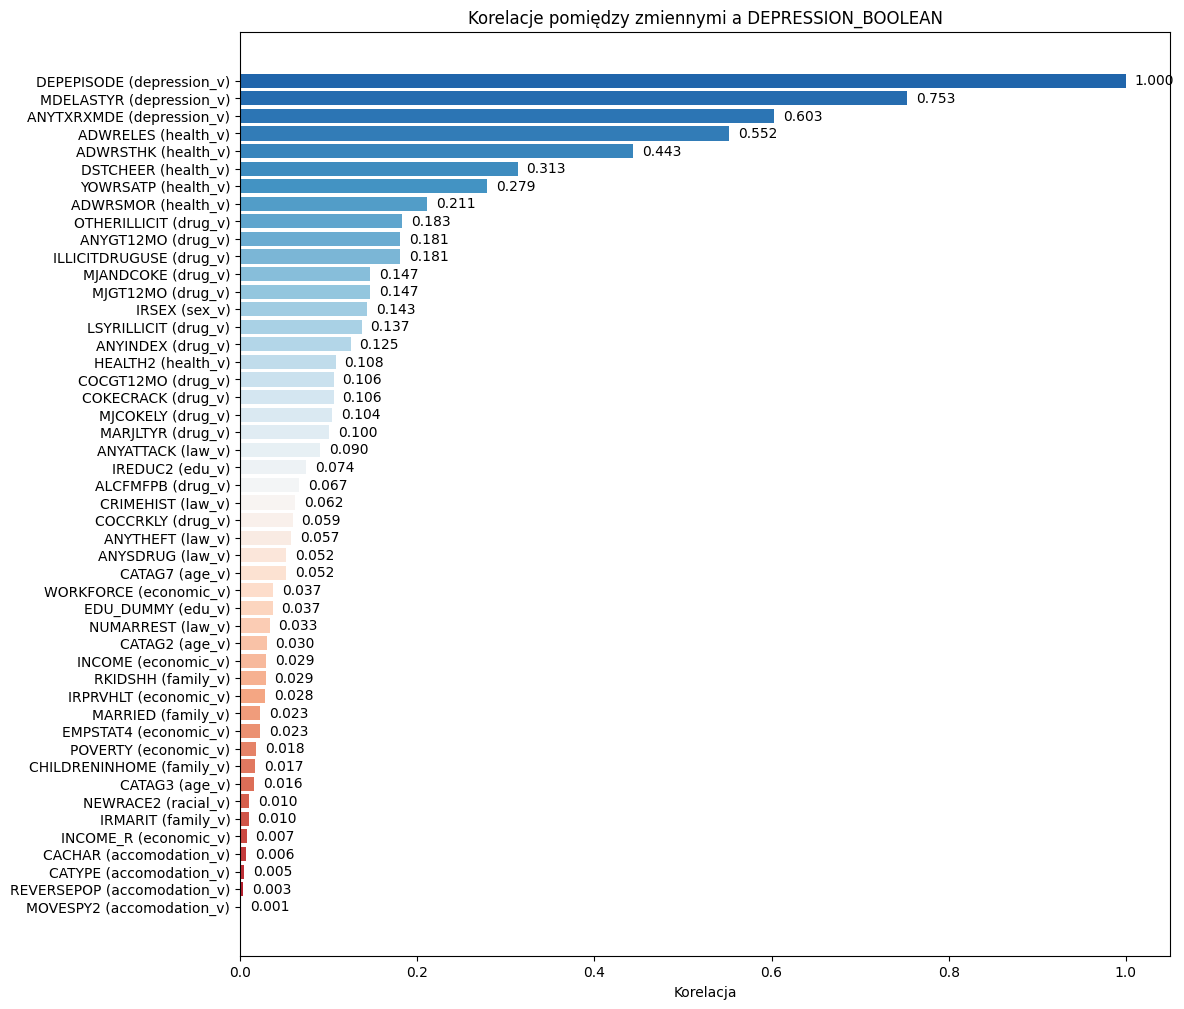

In [104]:
target='DEPRESSION_BOOLEAN'
corr_list = []
all_corr=None
category_corr=None

for category, corr_df in results_corr.items():
    category_corr = corr_df[target]
    category_corr.index = [f"{idx} ({category})" for idx in category_corr.index]
    corr_list.append(category_corr)
all_corr = pd.concat(corr_list)
all_corr = all_corr.reindex(all_corr.abs().sort_values().index)

plt.figure(figsize=(12, 12))
colors = plt.cm.RdBu(np.linspace(0.1, 0.9, len(all_corr)))
bars = plt.barh(range(len(all_corr)), all_corr, color=colors)

plt.yticks(range(len(all_corr)), all_corr.index)
plt.xlabel('Korelacja')
plt.title(f'Korelacje pomiędzy zmiennymi a {target}')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

for i, v in enumerate(all_corr):
    plt.text(v + (0.01 if v >= 0 else -0.01), 
             i, 
             f'{v:.3f}', 
             va='center',
             ha='left' if v >= 0 else 'right')
plt.show()

In [105]:
show=False
if show:
    target='DEPRESSIONINDEX'
    corr_list = []
    all_corr=None
    category_corr=None

    for category, corr_df in results_corr.items():
        category_corr = corr_df[target]
        category_corr.index = [f"{idx} ({category})" for idx in category_corr.index]
        corr_list.append(category_corr)
    all_corr = pd.concat(corr_list)
    all_corr = all_corr.reindex(all_corr.abs().sort_values().index)

    plt.figure(figsize=(12, 12))
    colors = plt.cm.RdBu(np.linspace(0.1, 0.9, len(all_corr)))
    bars = plt.barh(range(len(all_corr)), all_corr, color=colors)

    plt.yticks(range(len(all_corr)), all_corr.index)
    plt.xlabel('Korelacja')
    plt.title(f'Korelacje pomiędzy zmiennymi a {target}')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    for i, v in enumerate(all_corr):
        plt.text(v + (0.01 if v >= 0 else -0.01), 
                i, 
                f'{v:.3f}', 
                va='center',
                ha='left' if v >= 0 else 'right')
    plt.show()

In [106]:
show=False
if show:
    target='PSEUDO_SOMATIC_DEPRESSION'
    corr_list = []
    all_corr=None
    category_corr=None

    for category, corr_df in results_corr.items():
        category_corr = corr_df[target]
        category_corr.index = [f"{idx} ({category})" for idx in category_corr.index]
        corr_list.append(category_corr)
    all_corr = pd.concat(corr_list)
    all_corr = all_corr.reindex(all_corr.abs().sort_values().index)

    plt.figure(figsize=(12, 12))
    colors = plt.cm.RdBu(np.linspace(0.1, 0.9, len(all_corr)))
    bars = plt.barh(range(len(all_corr)), all_corr, color=colors)

    plt.yticks(range(len(all_corr)), all_corr.index)
    plt.xlabel('Korelacja')
    plt.title(f'Korelacje pomiędzy zmiennymi a {target}')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    for i, v in enumerate(all_corr):
        plt.text(v + (0.01 if v >= 0 else -0.01), 
                i, 
                f'{v:.3f}', 
                va='center',
                ha='left' if v >= 0 else 'right')
    plt.show()

Na podstawie analizy korelacyjnej możemy zauważyć że największe znaczenie na wskaźnik depresji ma... stwierdzenie wystąpienia depresji (niespodzianka!), oraz jej leczenie. Poza tymi znaczenie mają kolejno: zdrowie, używki, płeć (!) a w mniejszym stopniu konflikty z prawem czy edukacja.

#### Analiza Predictive Power Score

In [107]:
results_pps = {}
for category_name, category_vars in categories.items():
    valid_vars = [var for var in category_vars if var in main_df.columns]
    if not valid_vars:
        continue
    category_df = main_df[valid_vars + target_vars]
    pps_matrix = pd.DataFrame(index=valid_vars, columns=target_vars)
    for x in valid_vars:
        for y in target_vars:
            score = pps.score(category_df, x, y)
            pps_matrix.loc[x, y] = pps.score(category_df, x, y)['ppscore']
    results_pps[category_name] = pps_matrix.sort_values(by=target_vars, ascending=False)

for category, scores in results_pps.items():
    print(f"\n{category.upper()} PPS:")
    print(scores)


DEPRESSION_V PPS:
           DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
DEPEPISODE                1.0        0.769469                         0
MDELASTYR            0.281061        0.203261                         0
ANYTXRXMDE                  0               0                         0

AGE_V PPS:
       DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
CATAG7                  0               0                         0
CATAG2                  0               0                         0
CATAG3                  0               0                         0

SEX_V PPS:
      DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
IRSEX                  0               0                         0

RACIAL_V PPS:
         DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
NEWRACE2                  0               0                         0

DRUG_V PPS:
               DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
COCCRKLY           

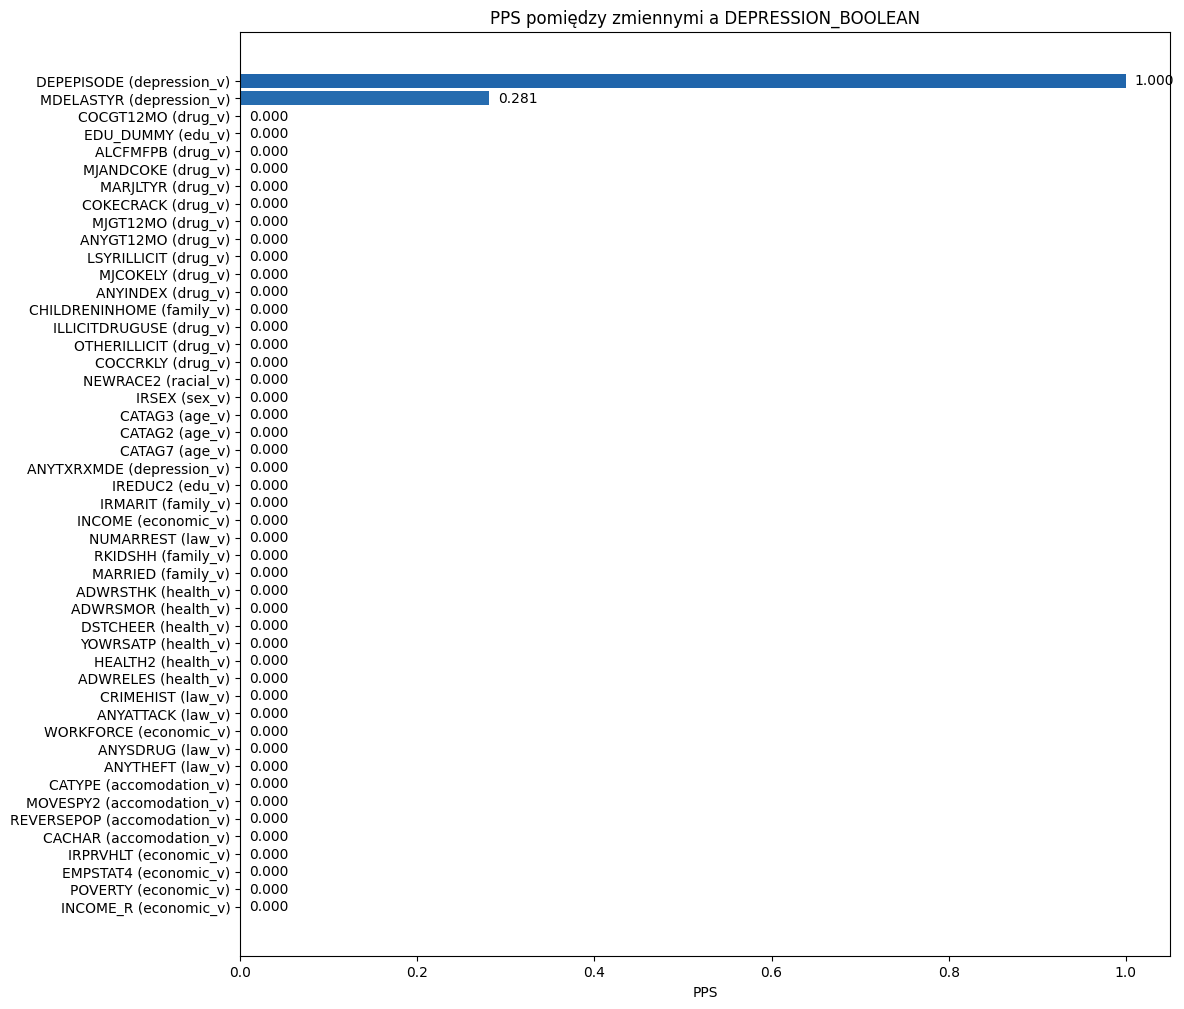

In [108]:
target='DEPRESSION_BOOLEAN'
pps_list = []
all_pps=None
category_pps=None

for category, pps_matrix in results_pps.items():
    category_pps = pps_matrix[target]
    category_pps.index = [f"{idx} ({category})" for idx in category_pps.index]
    pps_list.append(category_pps)
all_pps = pd.concat(pps_list)
all_pps = all_pps.reindex(all_pps.abs().sort_values().index)

plt.figure(figsize=(12, 12))
colors = plt.cm.RdBu(np.linspace(0.1, 0.9, len(all_pps)))
bars = plt.barh(range(len(all_pps)), all_pps, color=colors)

plt.yticks(range(len(all_pps)), all_pps.index)
plt.xlabel('PPS')
plt.title(f'PPS pomiędzy zmiennymi a {target}')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

for i, v in enumerate(all_pps):
    plt.text(v + (0.01 if v >= 0 else -0.01), 
             i, 
             f'{v:.3f}', 
             va='center',
             ha='left' if v >= 0 else 'right')
plt.show()

Według PPS jedyne znaczenie mają zmienne okreslające wystąpienie depresji.

#### Analiza Chi2

In [109]:
results_chi = {}
p_value={}

for category_name, category_vars in categories.items():
    valid_vars = [var for var in category_vars if var in main_df.columns]
    if not valid_vars:
        continue
    category_df = main_df[valid_vars + target_vars]
    chi2_matrix = pd.DataFrame(index=valid_vars, columns=target_vars)
    p_value_matrix = pd.DataFrame(index=valid_vars, columns=target_vars)
    for x in valid_vars:
        for y in target_vars:
            contingency = pd.crosstab(main_df[x], main_df[y])
            chi2, p_val, _, _ = chi2_contingency(contingency)
            chi2_matrix.loc[x, y] = chi2
            p_value_matrix.loc[x, y] = p_val
    results_chi[category_name] = chi2_matrix.sort_values(by=target_vars, ascending=False)
    p_value[category_name] = p_value_matrix.sort_values(by=target_vars, ascending=False)

for category, scores in results_chi.items():
    print(f"\n{category.upper()} CHI2:")
    print(scores)


DEPRESSION_V CHI2:
           DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
DEPEPISODE        34763.42775         34771.0                881.254194
MDELASTYR        19713.177643    20533.549021                191.331633
ANYTXRXMDE       12650.699527     13377.26295                249.370663

AGE_V CHI2:
       DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
CATAG7         272.748853      410.057391                187.917194
CATAG3         131.677709      241.456561                182.580378
CATAG2          58.217072      141.718309                175.445787

SEX_V CHI2:
      DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
IRSEX         713.319982       770.47015                 36.905135

RACIAL_V CHI2:
         DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
NEWRACE2          56.453993      133.604157                 12.178028

DRUG_V CHI2:
               DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
OTHERILLICIT  

In [110]:
for category, p_vals in p_value.items():
    print(f"\n{category.upper()} P-Value:")
    print(p_vals)


DEPRESSION_V P-Value:
           DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
MDELASTYR                 0.0             0.0                       0.0
ANYTXRXMDE                0.0             0.0                       0.0
DEPEPISODE                0.0             0.0                       0.0

AGE_V P-Value:
       DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
CATAG2                0.0             0.0                       0.0
CATAG3                0.0             0.0                       0.0
CATAG7                0.0             0.0                       0.0

SEX_V P-Value:
      DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
IRSEX                0.0             0.0                       0.0

RACIAL_V P-Value:
         DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION
NEWRACE2                0.0             0.0                  0.058113

DRUG_V P-Value:
               DEPRESSION_BOOLEAN DEPRESSIONINDEX PSEUDO_SOMATIC_DEPRESSION

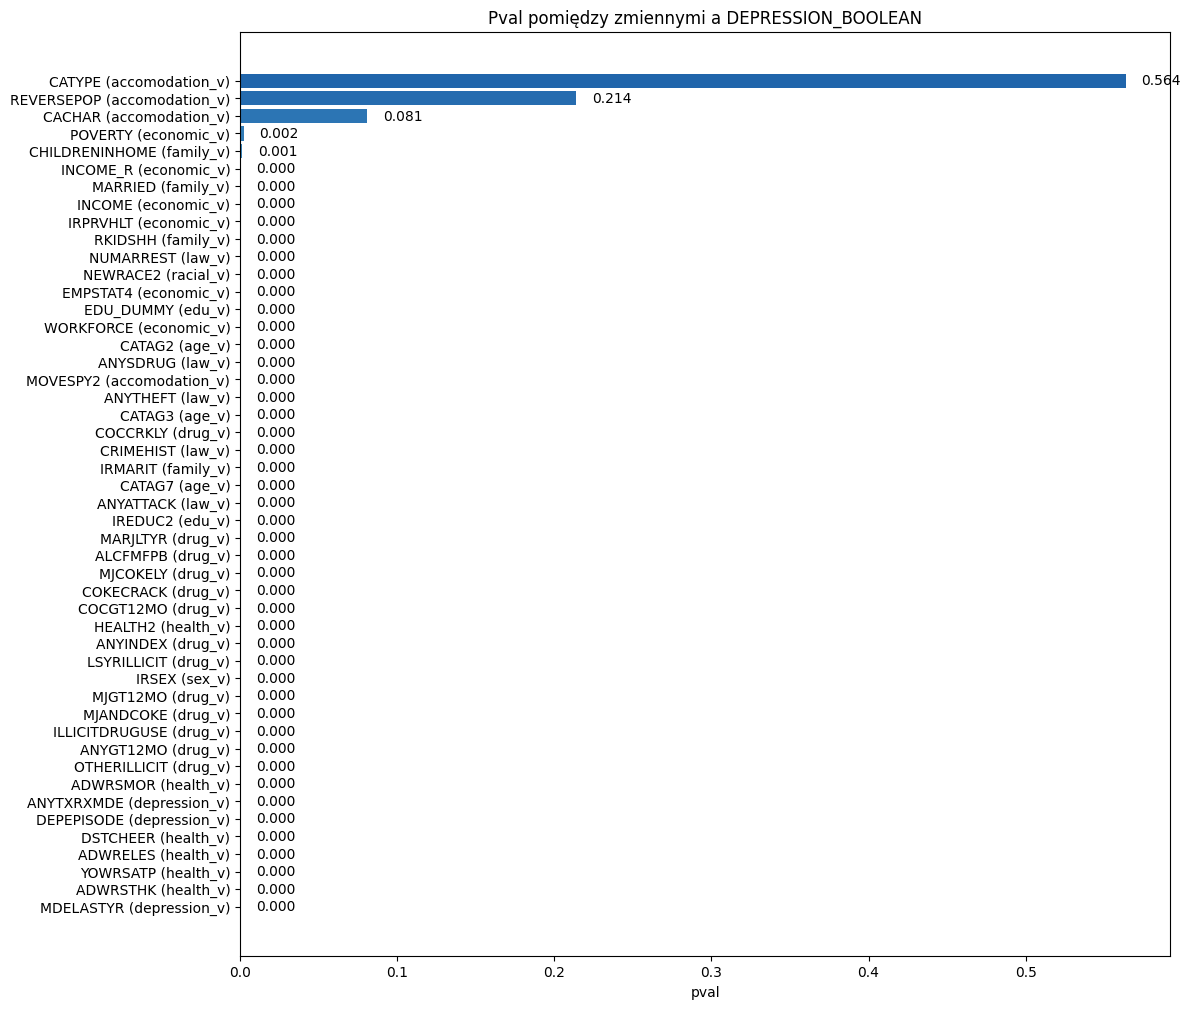

In [111]:
target='DEPRESSION_BOOLEAN'
pval_list = []
all_pval=None
category_pval=None

for category, pval_matrix in p_value.items():
    category_pval = pval_matrix[target]
    category_pval.index = [f"{idx} ({category})" for idx in category_pval.index]
    pval_list.append(category_pval)
all_pval = pd.concat(pval_list)
all_pval = all_pval.reindex(all_pval.abs().sort_values().index)

plt.figure(figsize=(12, 12))
colors = plt.cm.RdBu(np.linspace(0.1, 0.9, len(all_pval)))
bars = plt.barh(range(len(all_pval)), all_pval, color=colors)

plt.yticks(range(len(all_pval)), all_pval.index)
plt.xlabel('pval')
plt.title(f'Pval pomiędzy zmiennymi a {target}')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

for i, v in enumerate(all_pval):
    plt.text(v + (0.01 if v >= 0 else -0.01), 
             i, 
             f'{v:.3f}', 
             va='center',
             ha='left' if v >= 0 else 'right')
plt.show()

Na podstawie analizy chi2 oraz pval mozemy stwierdzic ze zmienne dotyczace zamieszkania sa malo istotne.

## 2) FAZA 2 - Predykcja

Celem tej fazy jest stworzenie modelu regresyjnego OLS umożliwiającego ocenę ryzyka depresji u danej osoby. Możemy tego dokonać na 2 sposoby, analizując stopień depresji (DEPRESSIONINDEX) albo 0/1 analizując wystąpienie depresji (DEPRESSION_BOOLEAN). Ignorujemy tutaj pseudo-somatyczną (ponieważ nie jest ona prawdziwą depresją somatyczną ze względu na brakującą zmienną).

Do realizacji modelu wybieramy następujące cechy (wybór stwierdzono na podstawie poprzednich analiz):
- ADWRELES (health)
- ADWRSTHK (health)
- DSTCHEER (health)
- YOWRSATP (health)
- ADWRSMOR (health)
- HEALTH2 (health)
- ILLICITDRUGUSE (drug)
- OTHERILLICIT (drug)
- ALCFMFPB (drug)
- IRSEX (sex)
- CATAG7 (age)
- CRIMEHIST (law)
- ANYATTACK (law)
- IREDUC2 (edu)
- WORKFORCE (economic)

In [154]:
x_labels=['ADWRELES','ADWRSTHK', 'DSTCHEER','ADWRSMOR','YOWRSATP' ,'ALCFMFPB','HEALTH2' ,'ILLICITDRUGUSE','OTHERILLICIT','IRSEX','ANYATTACK' ,'CATAG7' ,'CRIMEHIST' ,'IREDUC2' ,'WORKFORCE']
y_labels=['DEPRESSION_BOOLEAN','DEPRESSIONINDEX']
# do oględzin df wykorzystano rozszerzenie Data Wrangler w VSCode
prediction_df=main_df[x_labels+y_labels].copy()
value_map = {
    2:0,
}
prediction_df['ADWRELES'] = prediction_df['ADWRELES'].replace(value_map) # num -> binary
prediction_df['ADWRSMOR'] = prediction_df['ADWRSMOR'].replace(value_map) # num -> binary
prediction_df['YOWRSATP'] = prediction_df['YOWRSATP'].replace(value_map) # num -> binary
prediction_df['ADWRSTHK'] = prediction_df['ADWRSTHK'].replace(value_map) # num -> binary
prediction_df['ALCFMFPB'] = prediction_df['ALCFMFPB'].replace(value_map) # num -> binary
prediction_df['ILLICITDRUGUSE'] = prediction_df['ILLICITDRUGUSE'].replace(value_map) # num -> binary
prediction_df['IRSEX'] = prediction_df['IRSEX'].replace(value_map) # num -> binary

catag_dummies = pd.get_dummies(prediction_df['CATAG7'], prefix='CATAG7') # one hot encoding
prediction_df = prediction_df.drop('CATAG7', axis=1)
prediction_df = pd.concat([prediction_df, catag_dummies], axis=1)


In [155]:
for l in prediction_df.columns:
    print(l)
    print(prediction_df[l].value_counts().sort_index())
    print()


ADWRELES
0    32705
1     2066
Name: ADWRELES, dtype: int64

ADWRSTHK
0    33466
1     1305
Name: ADWRSTHK, dtype: int64

DSTCHEER
1      717
2     1494
3     2792
4     4151
5    25617
Name: DSTCHEER, dtype: int64

ADWRSMOR
0    34396
1      375
Name: ADWRSMOR, dtype: int64

YOWRSATP
0    34245
1      526
Name: YOWRSATP, dtype: int64

ALCFMFPB
0    33211
1     1560
Name: ALCFMFPB, dtype: int64

HEALTH2
1    10740
2    13934
3     7953
4     2144
Name: HEALTH2, dtype: int64

ILLICITDRUGUSE
0    20272
1    14499
Name: ILLICITDRUGUSE, dtype: int64

OTHERILLICIT
0    24904
1     9867
Name: OTHERILLICIT, dtype: int64

IRSEX
0    17961
1    16810
Name: IRSEX, dtype: int64

ANYATTACK
0    32883
1     1888
Name: ANYATTACK, dtype: int64

CRIMEHIST
0    30247
1     4524
Name: CRIMEHIST, dtype: int64

IREDUC2
1     1249
2     2897
3     3044
4     3255
5     3310
6     3184
7     2961
8     6165
9     1898
10    3177
11    3631
Name: IREDUC2, dtype: int64

WORKFORCE
0    19074
1    15697
Name: W

### a) Model stopnia depresji

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    prediction_df.drop(['DEPRESSION_BOOLEAN','DEPRESSIONINDEX'], axis=1),
    prediction_df['DEPRESSIONINDEX'],
    test_size=0.2,
    random_state=42,
    stratify=prediction_df[['CATAG7_1','CATAG7_2','CATAG7_3','CATAG7_4','CATAG7_5','CATAG7_6','CATAG7_7','DEPRESSIONINDEX']]
)

print("\nDystrybucja kategorii wiekowych w secie treningowym (przykład dla sprawdzenia):")
print(X_train['CATAG7_1'].value_counts(normalize=True).sort_index())
print("\nDystrybucja kategorii wiekowych w secie testowym (przykład dla sprawdzenia):")
print(X_test['CATAG7_1'].value_counts(normalize=True).sort_index())   


Dystrybucja kategorii wiekowych w secie treningowym (przykład):
0    0.834843
1    0.165157
Name: CATAG7_1, dtype: float64

Dystrybucja kategorii wiekowych w secie testowym (przykład):
0    0.834651
1    0.165349
Name: CATAG7_1, dtype: float64


In [186]:
model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train)).fit()

In [187]:
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:         DEPRESSIONINDEX   R-squared:                       0.530
Model:                             OLS   Adj. R-squared:                  0.530
Method:                  Least Squares   F-statistic:                     1567.
Date:              niedz., 26 sty 2025   Prob (F-statistic):               0.00
Time:                         22:12:06   Log-Likelihood:                -56941.
No. Observations:                27816   AIC:                         1.139e+05
Df Residuals:                    27795   BIC:                         1.141e+05
Df Model:                           20                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4505      0.0

In [188]:
y_pred = model.predict(sm.add_constant(X_test))
print(f"R^2: {model.rsquared}")

R^2: 0.5299169137998074


In [189]:
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 3.646064841659033


In [190]:
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 1.1390278052102343


In [198]:
y_pred_rounded=np.round(y_pred).astype(int) # zaokrąglenie do najbliższej liczby całkowitej

# delikatny postporcessing danych ze względu na logikę próby
y_pred_rounded=np.where(y_pred_rounded<0, 0, y_pred_rounded) # zamiana wartości ujemnych na 0
y_pred_rounded=np.where(y_pred_rounded>9, 9, y_pred_rounded) # zamiana wartości powyżej 10 na 10

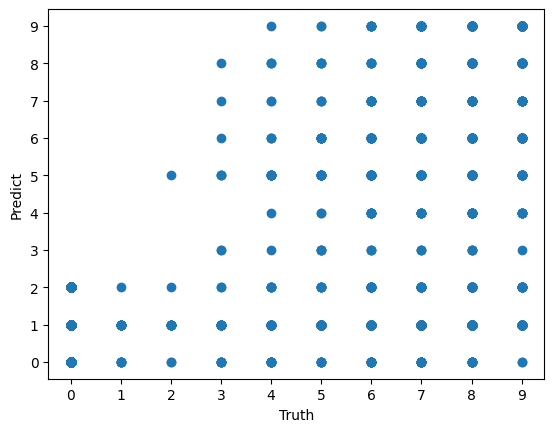

In [199]:
plt.scatter(y_test, y_pred_rounded)
plt.xlabel("Truth")
plt.ylabel("Predict")
plt.xticks(range(0, 10))
plt.yticks(range(0, 10))
plt.show()

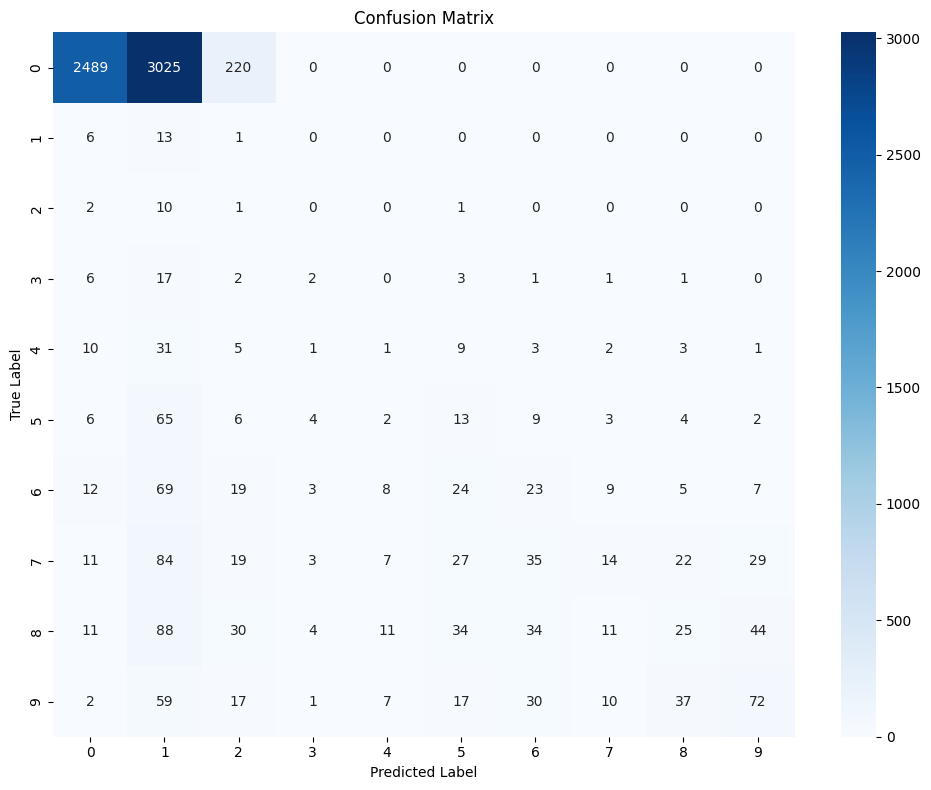

In [200]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred_rounded)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            cmap='Blues'
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Współczynnik determinacji modelu (R^2) jest miarą jak dobrze model tłumaczy zmienność danych w odpowiedzi.
Przyjmuje on wartości 0-1, gdzie 0: model nie tłumaczy żadnej zmienności, 1: model idelnie wyjaśnia zmienności.

Otrzymany wynik to 0.53 co oznacza że model jest średnio w stanie zmienności. Jest to spowodowane kilkoma problemami:
- Depresja w kontekście choroby
    - Depresja jest bardzo złożoną chorobą, i na zachorowanie wpływa ogrom czynników, poczynając od płci, wieku, edukacji, pracy, zamożności, wykształcenia, konczac na bardziej zlozonych jak branie uzywek, problemy z prawem, oraz tych ktore, w pewnym sensie, nie powinny byc wykorzystywane w badaniu/wywiadzie z osobą podejrzaną o depresję np. historia epizodów depresyjnych, występowanie depresji wśród rodziny/bliskich

- Złożoność problemu a prostota modelu
    - OLS to jeden z najprostrzych modeli który przybliża dość nietrywialny problem. Innym modelem który mógłby się lepiej sprawdzić w rozwiązywaniu przedstawionego problemu jest drzewo decyzyjne (implementacja niżej)

- Dane wejściowe
    - Pomijając fakt że wykorzystujemy dane złożone wyłącznie z obywateli USA z roku 2004, tak dane mają więcej przypadków braku depresji niż małej depresji lub dużej depresji. To może wpływać na bias modelu.


### b) Drzewo decyzyjne

In [201]:
tree_model = sklearn.tree.DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

In [202]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [203]:
y_pred_tree = tree_model.predict(X_test)


In [205]:
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:")
print(sklearn.metrics.classification_report(y_test, y_pred_tree))

Accuracy: 0.8529115744069015

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5734
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        33
           4       0.10      0.02      0.03        66
           5       0.00      0.00      0.00       114
           6       0.16      0.04      0.06       179
           7       0.28      0.11      0.16       251
           8       0.26      0.24      0.25       292
           9       0.45      0.37      0.41       252

    accuracy                           0.85      6955
   macro avg       0.22      0.18      0.19      6955
weighted avg       0.79      0.85      0.82      6955



c:\Users\szzal\Documents\Studia\EDA_Project2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\szzal\Documents\Studia\EDA_Project2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\szzal\Documents\Studia\EDA_Project2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Raport pokazuje że dokładność modelu jest na poziomie 0.85 co jest dobrym wynikiem. Z dokładnego raportu możemy jednak zauważyć że model bardzo dobrze radzi sobie z wykryciem braku depresji, gorzej z wysokim stanem depresji a fatalnie (a w sumie, nie radzi sobie) ze słabymi stanami depresji.

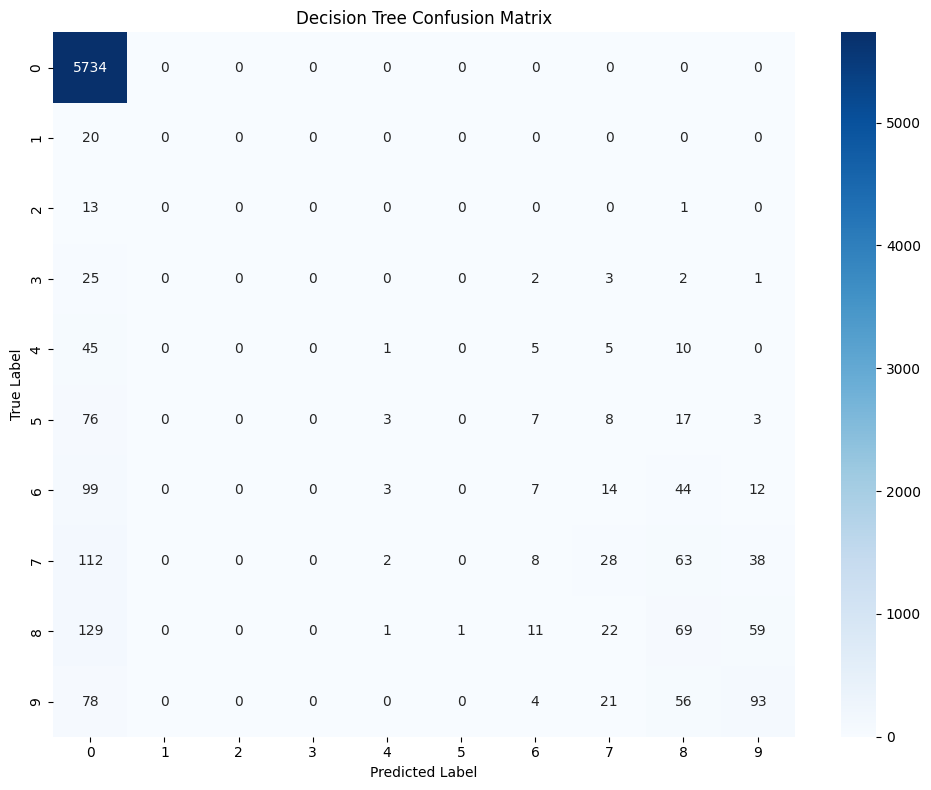

In [208]:
cm_tree = sklearn.metrics.confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_tree, 
            annot=True, 
            fmt='d',
            cmap='Blues'
)
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### c) Analiza wyjścia z modelu


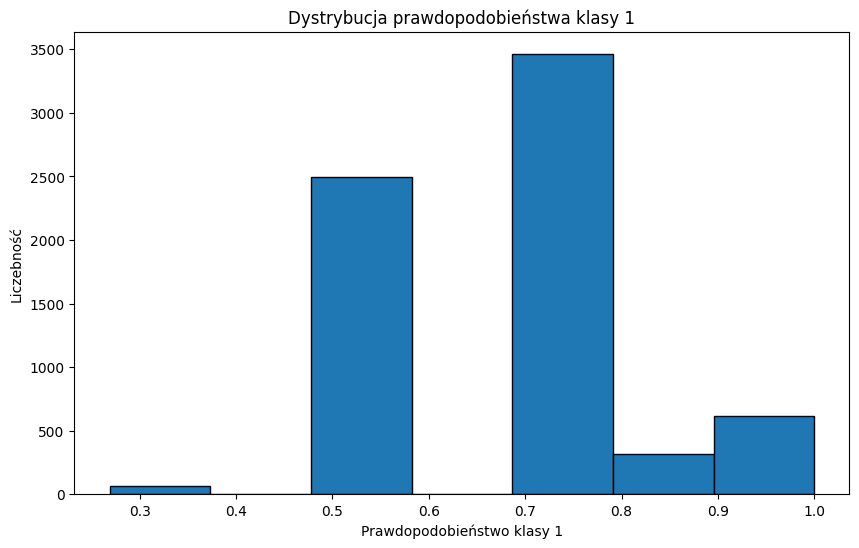

In [240]:
# Sigmoid function for probability conversion
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_prob = sigmoid(y_pred)

plt.figure(figsize=(10, 6))
plt.hist(y_prob, bins=7, edgecolor='black')
plt.title('Dystrybucja prawdopodobieństwa klasy 1')
plt.xlabel('Prawdopodobieństwo klasy 1')
plt.ylabel('Liczebność')
plt.show()

In [270]:
sorted_probs = np.sort(y_prob)
results_df = pd.DataFrame({
    'probability': y_prob,
    'actual': y_test
})
results_df = results_df.sort_values(by="probability").reset_index(drop=True)
num_groups = 3 # problemy z zakresami binów
quantiles = np.linspace(0, 1, num_groups + 1)
group_labels = [f"Grupa {i}" for i in range(num_groups)]
results_df["group"] = pd.qcut(results_df["probability"], q=quantiles, labels=group_labels,duplicates='drop')
risk = (
    results_df.groupby("group")["actual"].sum() / results_df.groupby("group")["actual"].count()
).reset_index()
risk.columns = ["group", "risk"]


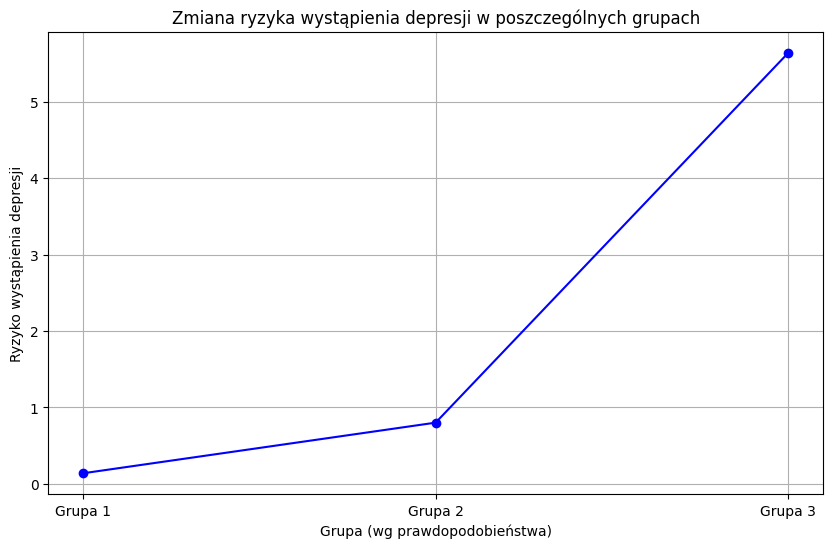

In [271]:
plt.figure(figsize=(10, 6))
plt.plot(risk["group"], risk["risk"], marker="o", linestyle="-", color="b")
plt.title("Zmiana ryzyka wystąpienia depresji w poszczególnych grupach")
plt.xlabel("Grupa (wg prawdopodobieństwa)")
plt.ylabel("Ryzyko wystąpienia depresji")
plt.xticks(range(num_groups), [f"Grupa {i+1}" for i in range(num_groups)])
plt.grid()
plt.show()

In [272]:
def classify_observation(prob, border, group):
    for i, (low, high) in enumerate(zip(border[:-1], border[1:])):
        if low <= prob < high:
            return group[i]
    return group[-1]

In [273]:
border = [results_df["probability"].quantile(q) for q in quantiles]

In [274]:
results_df["assigned"] = results_df["probability"].apply(
    lambda x: classify_observation(x, border, group_labels)
)

In [275]:
table = results_df[["probability", "assigned", "actual"]]
table.head()

,probability,assigned,actual
0,0.268941,Grupa 0,0
1,0.268941,Grupa 0,0
2,0.268941,Grupa 0,0
3,0.268941,Grupa 0,0
4,0.268941,Grupa 0,0


In [286]:
table['assigned_int']=table['assigned'].astype(str).str[-1].astype(int)
table['presumed']=table['actual'].apply(lambda x: 1 if x<=3 else (2 if x<=6 else 3))
table.head()

,probability,assigned,actual,assigned_int,presumed
0,0.268941,Grupa 0,0,0,1
1,0.268941,Grupa 0,0,0,1
2,0.268941,Grupa 0,0,0,1
3,0.268941,Grupa 0,0,0,1
4,0.268941,Grupa 0,0,0,1


In [287]:
matches=(table['assigned_int'] == table['presumed']).sum()
total=table.shape[0]
accuracy=matches/total
print(f"Dokładność: {accuracy:.2f}")

Dokładność: 0.40


Na podstawie posiadanych danych nie było możliwe podzielenie na równe 5-8 klas dlatego stworzono mniejszy model z 3 klasami. 